# Introduction: Exploration of an Alex Net Bird Classification Model
Date: 02/10/21


In [1]:
import torch
import matplotlib.pyplot as plt
import sys
import pandas as pd
import os
import numpy as np
sys.path.append("../") # moves sys path to parent which allows import of datasets module

from datasets.bird_dataset import BirdDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torchvision import transforms
from torch.nn.functional import softmax
from PIL import Image
from lime import lime_image

In [2]:
def get_image(tensor: torch.Tensor) -> Image:
    """
    reverse the normalization and returns Image obj w/ RGB
    """
    # imgNet mean, and std
    # should match bird_datasets values
    means = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    unnorm_tensor = tensor * stds + means
    return ToPILImage(mode='RGB')(unnorm_tensor)

def multiclass_confusion_matrix(true_y: list, pred_y: list) -> list:
    """
    takes in 1d true y and 1d predictions and spits out a 2d matrix containing
    of the confusion matrix.
    
    y-axis label is true
    x-axis lable is prediction 
    
    true_y and pred_y should correspond to 0 to k int labels
    """
    num_classes = len(np.unique(true_y))
    matrix = np.zeros((num_classes, num_classes))
    for i in range(len(true_y)):
        matrix[pred_y[i]][true_y[i]] += 1
    return matrix

In [3]:
# Intialization
LABEL_NAMES = tuple(os.listdir(f"../data/images/"))
test_dataset = BirdDataset(csv_path="../data/bird_test.csv", root_dir="../data/images")
test = DataLoader(test_dataset, batch_size=1)
model = torch.load("../models/alex_bird_classifier")

In [4]:
# Test Accuracy
num_correct = 0
with torch.no_grad(): # reduce memory comsumption
    for data, labels in test:
        predictions = model(data)
        num_correct += (predictions.argmax(axis=1) == labels).sum()
print(float(num_correct) / len(test_dataset))

0.915068493150685


The model is an pretrained Alex Net with the the last layer unfrozen. See `../models/generate_model.py` for implementation. We see that we have a model accuracy of ~90%, above random chance. We'll want to first implement a confusion matrix to see the general error

In [134]:
predicted_labels = []
true_labels = []
imgdata = []

with torch.no_grad(): # reduce memory comsumption
    for data, label in test:
        predictions = model(data)
        label_name = LABEL_NAMES[label]
        predicted_labels.append(predictions.argmax(axis=1)[0])
        true_labels.append(int(label[0]))
        imgdata.append({
                "data": data,
                "actual": label_name,
                "predicted": LABEL_NAMES[predictions.argmax(axis=1)[0]]
        })

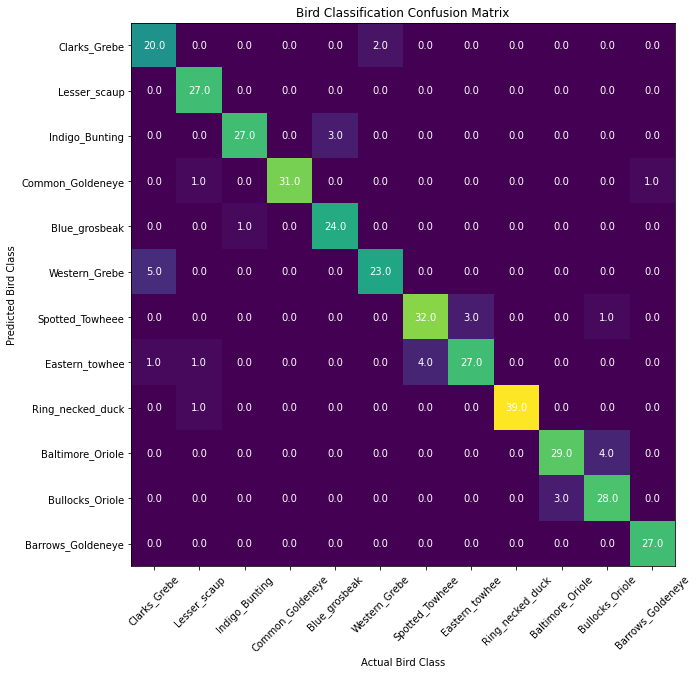

In [139]:
matrix = multiclass_confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(matrix)
plt.xticks(np.arange(len(LABEL_NAMES)), LABEL_NAMES, rotation=45)
plt.xlabel("Actual Bird Class")
plt.yticks(np.arange(len(LABEL_NAMES)), LABEL_NAMES)
plt.ylabel("Predicted Bird Class")
plt.title("Bird Classification Confusion Matrix")

for i in range(len(LABEL_NAMES)):
    for j in range(len(LABEL_NAMES)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="w")

plt.show()

Here we see some important confusion points:
* Clarks Grebe and Western Grebe have the highest error rate 
* Baltimore_Oriole and Bullocks_Oriole have the second highest error rate mixup
* Spotted_Towheee and Eastern_towhee have the third highest error rate

Judging by the naming of the three pairs, it is quite possible that because they are of similar species, theyre appearances are similar hence the model had difficulty discerning the differences between the two species. If we were to quanitify this errorage, use the f1 score on a binary classification containing the two species.

Note: A better visualization would require some interactivity: click box to expand the image samples. Unfortunately this functionality is difficult and time consuming in matplotlib/seaborn. D3.js would be the better tool. For now, a quick script works "good enough" as seen right below

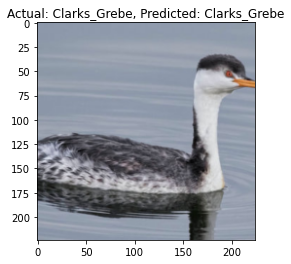

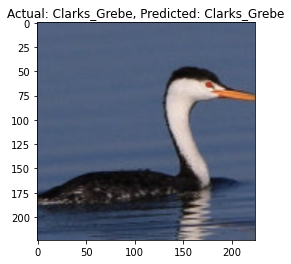

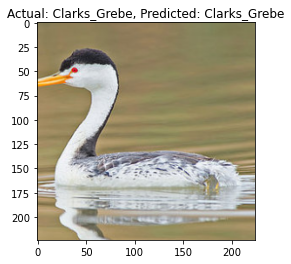

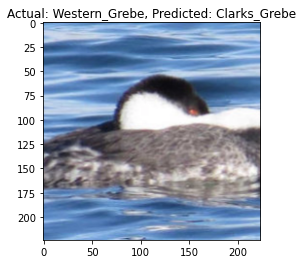

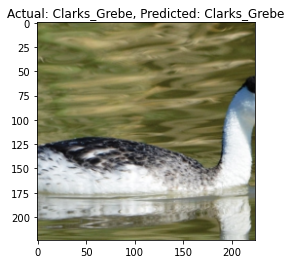

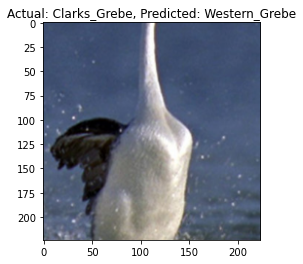

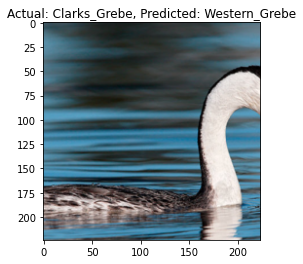

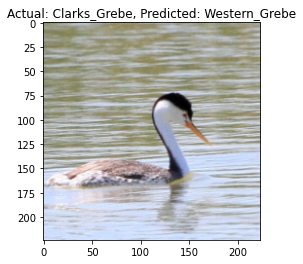

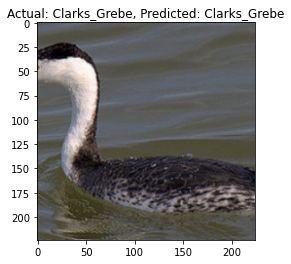

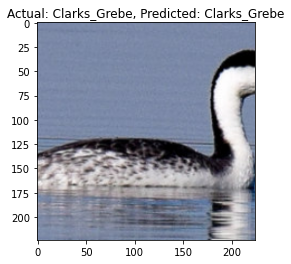

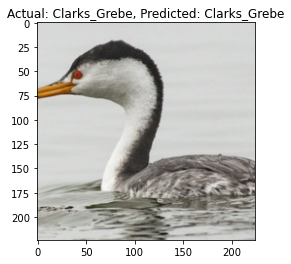

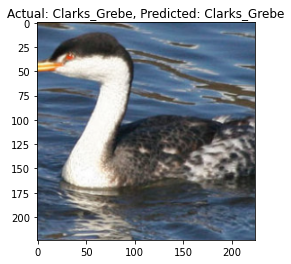

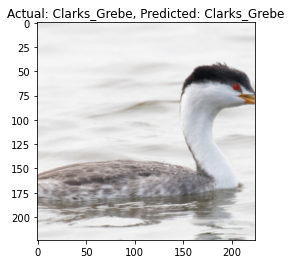

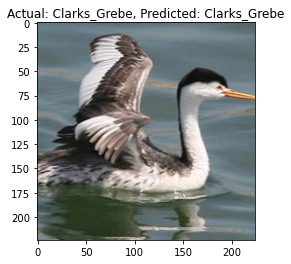

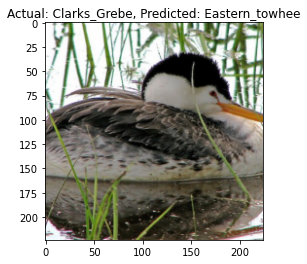

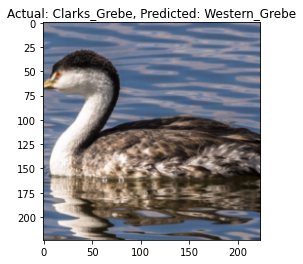

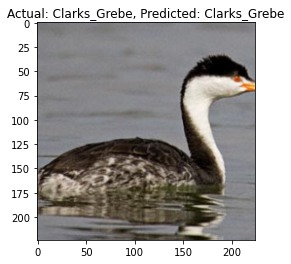

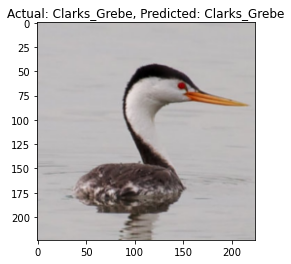

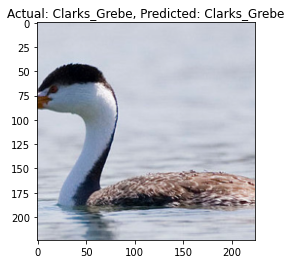

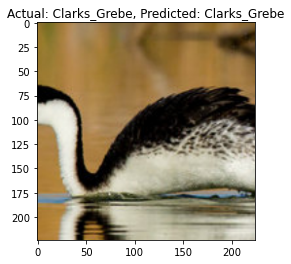

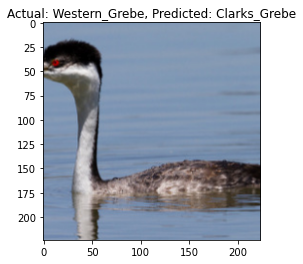

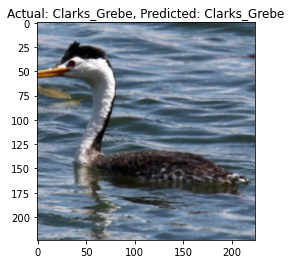

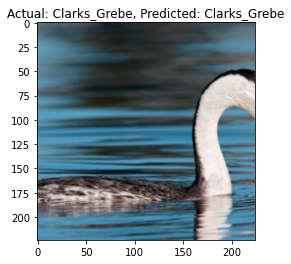

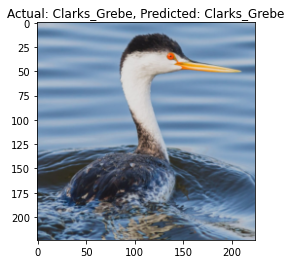

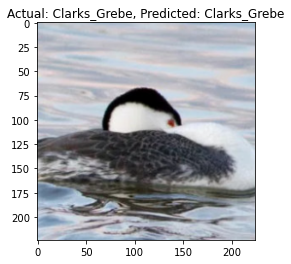

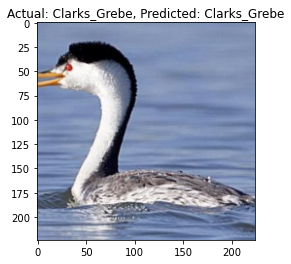

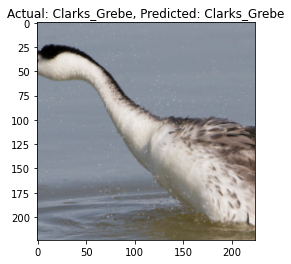

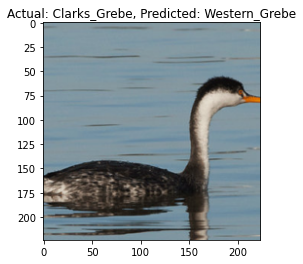

In [138]:
# CHANGE ME to look at other bird comparisons
actual_label_ft = "Clarks_Grebe"
predicted_label_ft = "Clarks_Grebe"

for error in imgdata:
    if error["actual"] == actual_label_ft or error["predicted"] == predicted_label_ft:
        plt.imshow(get_image(error["data"][0]))
        plt.title(f"Actual: {error['actual']}, Predicted: {error['predicted']}")
        plt.show()

In a large portion of the mistakes seen in the clarks grebe, the mistakes come from the certain features (specifically the beak) being completely or partially cropped off. There is one image where the full body is present, but we see that there is a mistaken attribution. It'd be interesting to explore this image specifically.


Lets utilize LIME to see the "thinking process" of the model under for Clarks_Grebe classification

In [9]:
# Pull images
dirs = [os.path.join("../data/images", d) for d in os.listdir("../data/images")]
clark_grebe_files = [os.path.join(dirs[0], f) for f in os.listdir(dirs[0])]
img = Image.open(clark_grebe_files[0]) # DataLoader format incorrect since it contains post-transformed data.

# Transformers
crop = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224)
])

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
    ])    

In [129]:
def lime_model(image):
    """
    I'm not 100% certain as to why the crops are seperated
    might have to do with the source code functionality assumptions
    requires probability output,
    """
    batch = normalize(image).unsqueeze(0)
    logits = model(batch)
    print(logits)
    probs = softmax(logits, dim=1)
    return probs.detach().numpy()

In [130]:
model(normalize(crop(img)).unsqueeze(0))

tensor([[ -2.2962,  -8.6162,  -9.3390,  -4.7861, -10.3124,  -2.3262,  -4.3970,
          -1.7125,  -7.5624,  -9.1657,  -5.6435,  -6.3925]],
       grad_fn=<AddmmBackward>)

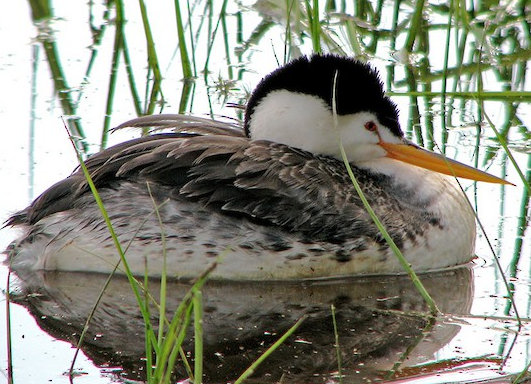

In [132]:
img

In [131]:
test_pred = lime_model(crop(img))
test_pred.squeeze().argmax() # mistakenly attributed to towhee?

tensor([[ -2.2962,  -8.6162,  -9.3390,  -4.7861, -10.3124,  -2.3262,  -4.3970,
          -1.7125,  -7.5624,  -9.1657,  -5.6435,  -6.3925]],
       grad_fn=<AddmmBackward>)


7

tensor([[[[-0.4911, -0.4397, -0.3712,  ..., -0.4054, -0.5253, -0.5596],
          [-0.6794, -0.6623, -0.6794,  ..., -0.3369, -0.4739, -0.5424],
          [-0.6965, -0.7137, -0.7137,  ..., -0.3198, -0.4054, -0.4739],
          ...,
          [ 0.2453,  0.0227, -0.6109,  ..., -0.7650, -0.7993, -0.8164],
          [-0.2513, -0.4397, -0.8164,  ..., -0.7993, -0.8507, -0.7822],
          [-1.1247, -1.2274, -1.2959,  ..., -0.8507, -0.8678, -0.7822]],

         [[ 0.5728,  0.6078,  0.6429,  ...,  0.6429,  0.6078,  0.5553],
          [ 0.4328,  0.4328,  0.4153,  ...,  0.6954,  0.6254,  0.5553],
          [ 0.3978,  0.3803,  0.3978,  ...,  0.6604,  0.6604,  0.6078],
          ...,
          [ 0.5203,  0.4678,  0.0301,  ...,  0.3627,  0.3102,  0.2752],
          [ 0.2052,  0.1527, -0.0749,  ...,  0.3102,  0.2752,  0.3102],
          [-0.5126, -0.4951, -0.4951,  ...,  0.2577,  0.2402,  0.3102]],

         [[ 1.6465,  1.6640,  1.6814,  ...,  1.7511,  1.7163,  1.7163],
          [ 1.6117,  1.6291,  

In [62]:
test_pred

array([[2.4818283e-01],
       [4.4670113e-04],
       [2.1683470e-04],
       [2.0579720e-02],
       [8.1915947e-05],
       [2.4084143e-01],
       [3.0368276e-02],
       [4.4488370e-01],
       [1.2814666e-03],
       [2.5785563e-04],
       [8.7310504e-03],
       [4.1282345e-03]], dtype=float32)

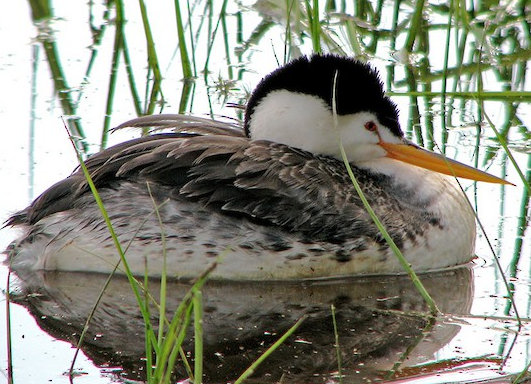

In [58]:
img

In [57]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image=np.array(crop(img)), 
                                         classifier_fn=lime_model,
                                         top_labels=2,
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
torch.Size([10, 12])
torch.Size([10, 3, 224, 224])
t

In [ ]:
.shape